In [247]:
pip install yfinance

In [248]:
import yfinance as yf

In [249]:
tsla = yf.Ticker('TSLA')
print(tsla.info)
hist = tsla.history(period='4000d')

{'zip': '94304', 'sector': 'Consumer Cyclical', 'fullTimeEmployees': 70757, 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and vehicle insurance, as well as sale of products through its subsidiaries to third party customers; services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians; and veh

In [250]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0
2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0
2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0
2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0
2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0


In [251]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-26,1024.689941,1094.939941,1001.440002,1018.429993,62415000,0,0.0
2021-10-27,1039.660034,1070.880005,1030.780029,1037.859985,38526500,0,0.0
2021-10-28,1068.310059,1081.000000,1054.199951,1077.040039,27213200,0,0.0
2021-10-29,1081.859985,1115.209961,1073.209961,1114.000000,29918400,0,0.0
2021-11-01,1145.000000,1209.750000,1118.660034,1208.589966,55814100,0,0.0


In [252]:
hist.shape

(2857, 7)

In [253]:
import matplotlib.pyplot as plt 
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout,LSTM
import pandas as pd
import numpy as np 

In [254]:
# preparing the data for neural network 
scaler = MinMaxScaler(feature_range=(0,1)) # scalling the data in btw 0-1 
scaled_data = scaler.fit_transform(hist['Close'].values.reshape(-1,1))

predication_days = 20  # past data 
x_train=[]
y_train =[] 

for x in range(predication_days,len(scaled_data)):
  x_train.append(scaled_data[x-predication_days:x,0])
  y_train.append(scaled_data[x,0])

x_train ,y_train = np.array(x_train) ,np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))

In [255]:
# building the model 
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1 ))) #input layer reshaped 
model.add(Dropout(0.2))
# layer 1 
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
# layer 2
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# prediction of next closing vlaue 
model.add(Dense(units=1))

In [256]:
# compiling the model 
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs =25,batch_size=32 ) # 32 units at once


Epoch 1/25
89/89 [==============================] - 9s 35ms/step - loss: 0.0031
Epoch 2/25
89/89 [==============================] - 3s 35ms/step - loss: 9.5308e-04
Epoch 3/25
89/89 [==============================] - 3s 34ms/step - loss: 8.2578e-04
Epoch 4/25
89/89 [==============================] - 3s 33ms/step - loss: 6.3827e-04
Epoch 5/25
89/89 [==============================] - 3s 34ms/step - loss: 7.5794e-04
Epoch 6/25
89/89 [==============================] - 3s 34ms/step - loss: 7.3557e-04
Epoch 7/25
89/89 [==============================] - 3s 34ms/step - loss: 7.3232e-04
Epoch 8/25
89/89 [==============================] - 3s 35ms/step - loss: 5.7819e-04
Epoch 9/25
89/89 [==============================] - 3s 35ms/step - loss: 7.2496e-04
Epoch 10/25
89/89 [==============================] - 3s 33ms/step - loss: 5.2155e-04
Epoch 11/25
89/89 [==============================] - 3s 33ms/step - loss: 7.7593e-04
Epoch 12/25
89/89 [==============================] - 3s 34ms/step - loss: 6.18

In [257]:
""" lets test the model accuracy on existing data """


test_data = yf.download("TSLA", start="2021-10-01", end="2021-11-01")


[*********************100%***********************]  1 of 1 completed


In [258]:
actual_price = test_data['Close'].values

total_data =pd.concat((data['Close'],test_data['Close']),axis =0)

In [259]:
model_inputs = total_data[len(total_data) - len(test_data) - predication_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [260]:
# make test data prediction 
x_test=[]
for x in range(predication_days,len(model_inputs)):
  x_test.append(model_inputs[x-predication_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],  1))

In [261]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

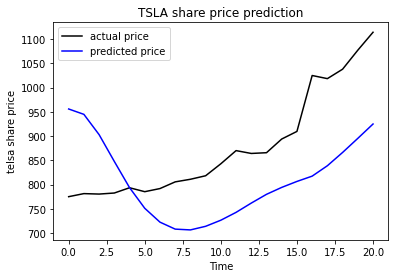

In [262]:
# plotting test prices 
plt.plot(actual_price,color='black',label='actual price')
plt.plot(predicted_prices,color ='blue',label ='predicted price')
plt.title('TSLA share price prediction')
plt.xlabel('Time')
plt.ylabel('telsa share price')
plt.legend()
plt.show()


In [269]:
# lets predict nextday
real_data = [model_inputs[len(model_inputs) + 1 -predication_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(str(prediction))

[[952.7051]]
